In [1]:
%pylab inline
from siph import *


import h5py
import condor

/Users/hantke/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data(experiment, run_number, N=10, skip=1):
    filename = "/Users/hantke/davinci/scratch/fhgfs/xray/%s/preproc/%s_r%04i_ol3.h5" % (experiment,experiment,run_number)
    with h5py.File(filename, "r") as f:
        imgs = asarray(f["entry_1/data_1/data"][-N-skip:-skip])
        msk = asarray(f["entry_1/data_1/mask"])
        gains = asarray(f["entry_1/detector_1/gain"][-N-skip:-skip])
        photon_energies_SLAC = asarray(f["entry_1/FEL/photon_energy_eV_SLAC"][-N-skip:-skip])
        gmds = asarray(f["entry_1/detector_3/pulse_energy_mJ"][-N-skip:-skip])
    return imgs, msk, gains, photon_energies_SLAC, gmds

def apply_mask(imgs, msk):
    tmp = asarray([(msk&condor.utils.pixelmask.PixelMask.PIXEL_IS_IN_MASK)==0])
    tmp = repeat(tmp, imgs.shape[0], axis=0)
    values = imgs.flatten()[tmp.flatten()]
    return values
    

(0, 10000)

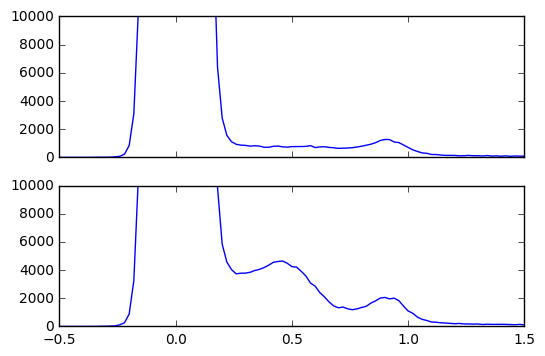

In [3]:
nbins = 101
ex = "amol3416"
N = 10

fig, axs = subplots(2, 1, sharey=True, sharex=True)

# No gas
r = 154
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk)
photons = values / gains.mean()
I_1, H_1 = histogram(photons, nbins=nbins)
axs[0].plot(I_1, H_1)

# Only N2
r = 152
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk)
photons = values / gains.mean()
I_N2, H_N2 = histogram(photons, nbins=nbins)
axs[1].plot(I_N2, H_N2)

#from python_tools import gentools 
#[A0, x0, sigma], Hest = gentools.gaussian_fit(I, H)
#print "A0", A0
#print "x0", x0
#print "sigma", sigma
#print I.shape,H.shape

ylim(0, 10000)

0.161381054432 21.1738050334 9969581 -0.0495637949492

(0.0, 20000)

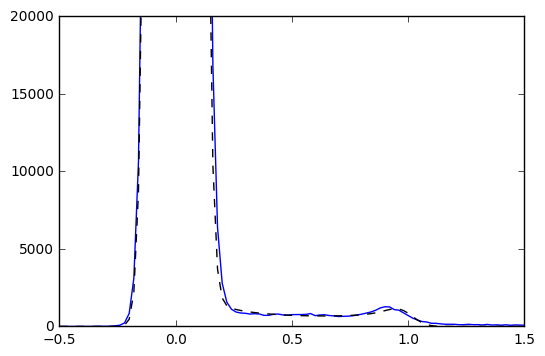

In [4]:
sigma0 = 0.25
L0 = 10
noise_sigma0 = 0.2
sigma_fit, L_fit, nphotons_fit, noise_sigma_fit = fit_hist2(H_1, sigma=sigma0, L=L0, 
                                                           noise_sigma=noise_sigma0)
I_1_fit, H_1_fit = hist_I(sigma_fit, L_fit, nphotons_fit, noise_sigma=noise_sigma_fit, nbins=nbins)

print sigma_fit, L_fit, nphotons_fit, noise_sigma_fit,
plot(I_1, H_1)
plot(I_1_fit, H_1_fit, "--", color="black")
ylim(None, 20000)

(0.0, 10000)

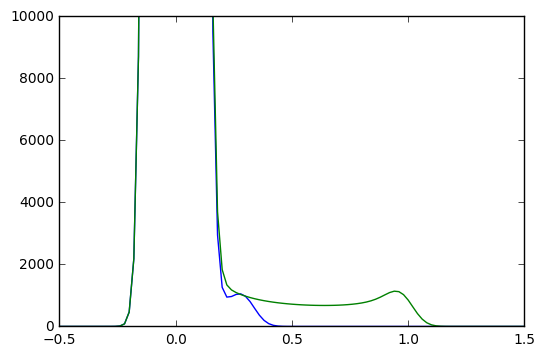

In [5]:
Itmp, Htmp = hist_I(sigma_fit, L_fit, nphotons_fit, noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=0.3)
plot(Itmp, Htmp)
Itmp, Htmp = hist_I(sigma_fit, L_fit, nphotons_fit, noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=1.0)
plot(Itmp, Htmp)
ylim(None, 10000)

In [74]:
print L_fit


21.1738050334


In [112]:
hist_I_1 = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
                                             nbins=nbins, photon_energy=1.0)[1]

wl_N_Kalpha = 3.16E-9
EeV_N_Kalpha = condor.source.Photon(wavelength=wl_N_Kalpha).get_energy_eV()
EeV_photon = np.median(photon_energies_SLAC)
print EeV_N_Kalpha, EeV_photon
hist_I_N = lambda sigma, L, nphotons: hist_I(sigma, L, nphotons, noise_sigma=noise_sigma_fit,
                                             nbins=nbins, photon_energy=EeV_N_Kalpha/EeV_photon)[1]

H_sum = lambda L, nphotons1, sigmaN, nphotonsN: hist_I_1(abs(L), abs(nphotons1)) \
                                                           + hist_I_N(abs(sigmaN), abs(L), abs(nphotonsN))
func = lambda x: (H_N2 - H_sum(x[0], x[1], x[2], x[3]))/(H_N2 + H_sum(x[0], x[1], x[2], x[3]))
x = scipy.optimize.leastsq(func, [L_fit, 1000., sigma_fit, 1000.])[0]
x = abs(array(x))
[L_fit2, nphotons1_fit, sigmaN_fit, nphotonsN_fit] = x
print x

392.355055052 777.987386758
[  1.22102429e+01   7.08910142e+06   3.23044797e-01   5.28263001e+06]


(0, 10000)

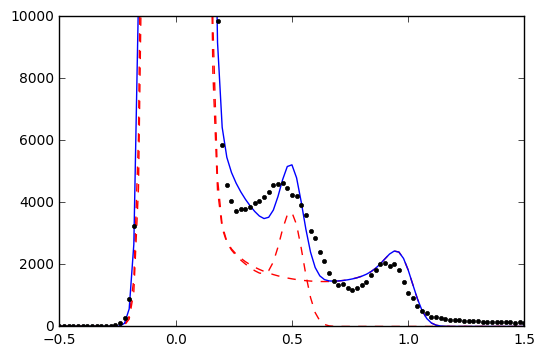

In [113]:
I = linspace(-0.5, 1.5, nbins)
L_guessed = L_fit2
H_1 = hist_I_1(L_guessed, nphotons1_fit)
H_N = hist_I_N(sigmaN_fit, L_guessed, nphotonsN_fit)

#c1 = 1.8
#cN = 3.2
I = linspace(-0.5, 1.5, nbins)
plot(I, H_1, "--", c='red')
plot(I, H_N, "--", c='red')
plot(I, H_1+H_N)
plot(I, H_N2, ".", c="black")
#plot(I[nbins/2:], func([c1_fit, cN_fit]))
#plot(I[nbins/2:], func([1.8, 3.2]))
#plot(I, H_sum(1.8, 3.2))
ylim(0, 10000)

In [114]:
print L_fit2, sigma_fit, nphotons1_fit
print L_fit2, sigmaN_fit, nphotonsN_fit

12.2102428703 0.161381054432 7089101.41577
12.2102428703 0.323044797027 5282630.00979
